In [1]:
import cv2
import numpy as np
from PIL import Image
from functools import reduce
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import argparse
import datetime
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from sklearn.cluster import MeanShift, estimate_bandwidth
import math
import random
from scipy.spatial import distance

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Image 4


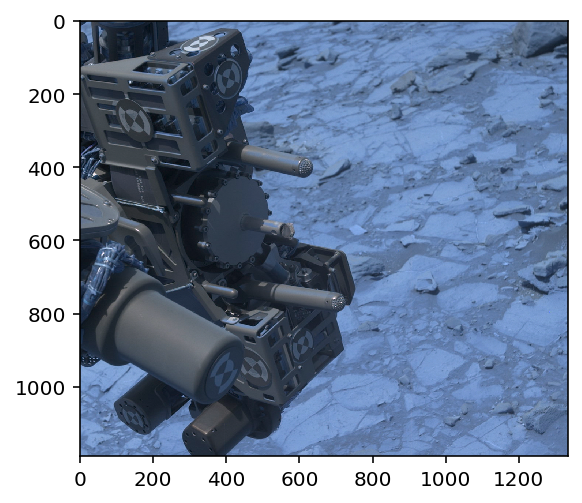

In [16]:
#input of the image
whatimg=int(input("Image"))
if whatimg==1:
    img = cv2.imread('image1.tif')
    height,width=img.shape[0],img.shape[1]
    Img=img[10:height-15,170:width-180]
    plt.imshow(Img)
elif whatimg==2:
    img = cv2.imread('image2.tif')
    height,width=img.shape[0],img.shape[1]
    Img=img[10:height-10,10:width-10]
    plt.imshow(Img)
elif whatimg==3:
    img = cv2.imread('image3.tif')
    height,width=img.shape[0],img.shape[1]
    Img=img[10:height-15,170:width-180]
    plt.imshow(Img)
elif whatimg==4:
    img = cv2.imread('image4.tif')
    height,width=img.shape[0],img.shape[1]
    Img=img[10:height-10,10:width-10]
    plt.imshow(Img)

Color Mode(RGB,HSV,Lab,yCrCb,XYZ,LUV,YUV,gray): HSV


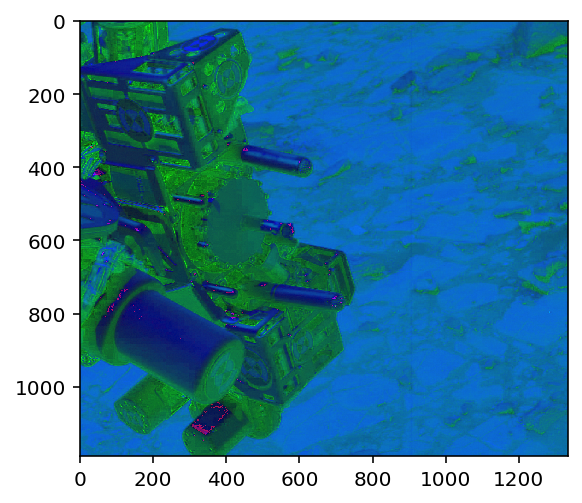

In [17]:
#color space transformation
colorsp=input("Color Mode(RGB,HSV,Lab,yCrCb,XYZ,LUV,YUV,gray):")
if colorsp=="RGB":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB )
    plt.imshow(Imag)
elif colorsp=="HSV":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2HSV )
    plt.imshow(Imag)
elif colorsp=="Lab":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2LAB )
    plt.imshow(Imag)
elif colorsp=="yCrCb":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2YCrCb)
    plt.imshow(Imag)
elif colorsp=="XYZ":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2XYZ)
    plt.imshow(Imag)   
elif colorsp=="LUV":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2LUV)
    plt.imshow(Imag)
elif colorsp=="YUV":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2YUV)
    plt.imshow(Imag)
elif colorsp=="gray":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)
    plt.imshow(Imag) 

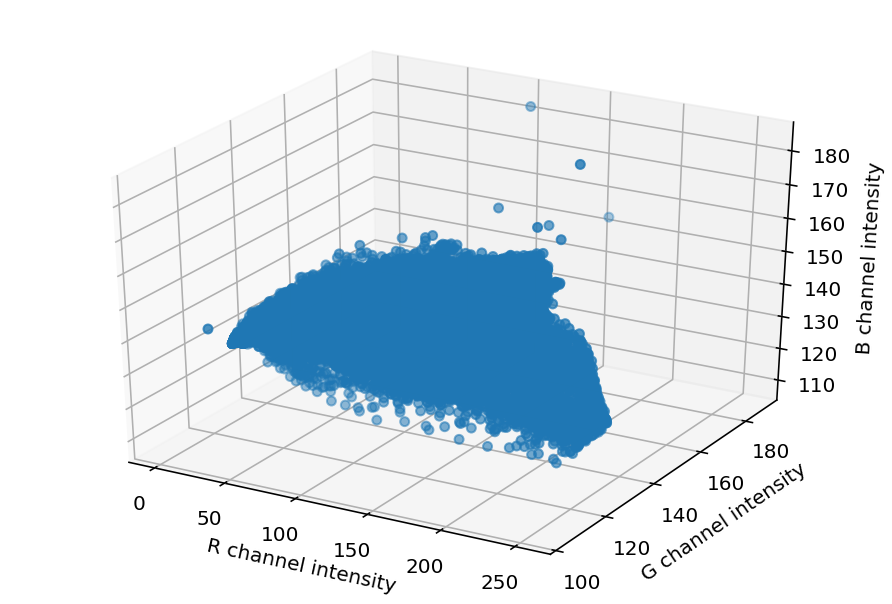

In [49]:
#3-D scatter plot visulization of the original image
r, g, b = cv2.split(Imag)
r = r.flatten()
g = g.flatten()
b = b.flatten()#plotting 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
ax.set_xlabel('R channel intensity')
ax.set_ylabel('G channel intensity')
ax.set_zlabel('B channel intensity')
plt.show()

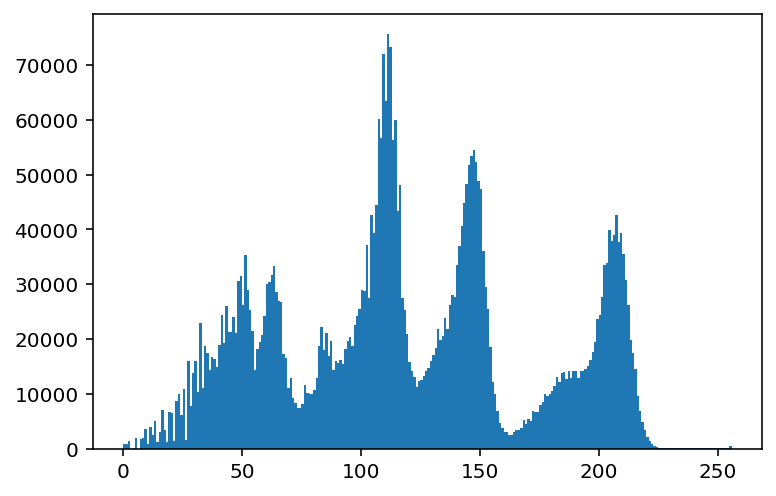

In [44]:
#histogram visualization
plt.hist(Img.ravel(),256,[0,256]); plt.show()

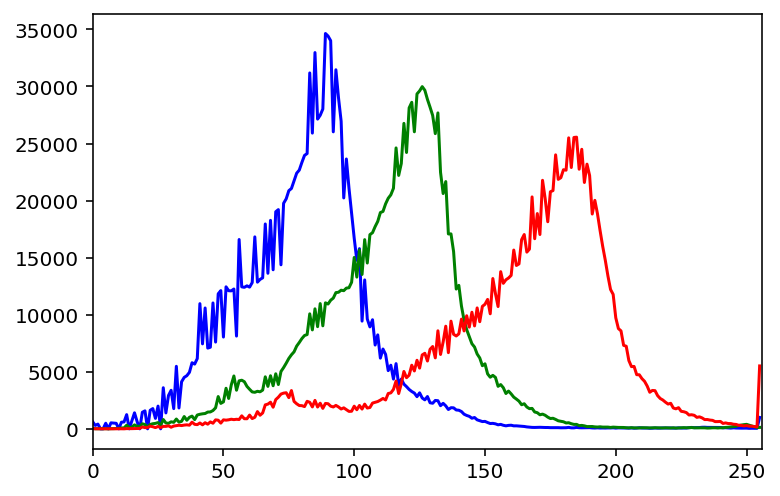

In [13]:
#find the histogram of the BGR image
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([Img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

In [ ]:
#regular linear stretching/contrast stretching
RGBTorF=input()
if RGBTorF=="T":
    #find the largest and smallest R,G,B intensity values in each image
    Rmax=np.amax(img[:,:,0])
    Rmin=np.amin(img[:,:,0])
    Gmax=np.amax(img[:,:,1])
    Gmin=np.amin(img[:,:,1])
    Bmax=np.amax(img[:,:,2])
    Bmin=np.amin(img[:,:,2])
    
    def normalizeRed(intensity):
        iI = intensity
        minI = Rmin
        maxI = Rmax
        minO = 0
        maxO = 255

        return (iI-minI)*(((maxO-minO)/(maxI-minI))+minO)
    #method to process the green band of the image
    def normalizeGreen(intensity):
        iI      = intensity
        minI    = Gmin
        maxI    = Gmax
        minO    = 0
        maxO    = 255
        return (iI-minI)*(((maxO-minO)/(maxI-minI))+minO)
    #method to process the blue band of the image
    def normalizeBlue(intensity):
        iI      = intensity
        minI    = Bmin
        maxI    = Bmax
        minO    = 0
        maxO    = 255
        return (iI-minI)*(((maxO-minO)/(maxI-minI))+minO)
    imageObject = Image.fromarray(Imag)#convert opencv format to PIL format
    multiBands = imageObject.split()# Split the red, green and blue bands from the Image
    normalizedRedBand      = multiBands[0].point(normalizeRed)
    normalizedGreenBand    = multiBands[1].point(normalizeGreen)
    normalizedBlueBand     = multiBands[2].point(normalizeBlue) # Apply point operations that does contrast stretching on each color band
    normalizedImage = Image.merge("RGB", (normalizedRedBand, normalizedGreenBand, normalizedBlueBand))# Create a new image from the contrast stretched red, green and blue bran
    plt.imshow(normalizedImage)
else:
    pass

 T


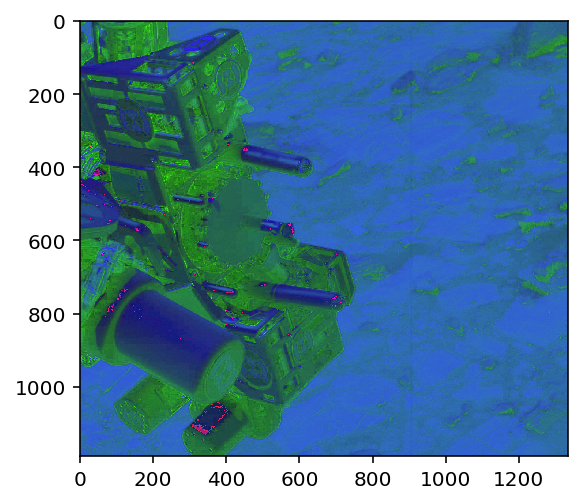

In [18]:
DeStrTorF=input()
if DeStrTorF=="T":
    def decorrstretch(A, tol=None):
        orig_shape = A.shape
        A = A.reshape((-1,3)).astype(np.float)
        cov = np.cov(A.T)# covariance matrix of A
        sigma = np.diag(np.sqrt(cov.diagonal())) # source and target sigma
        eigval, V = np.linalg.eig(cov)# eigen decomposition of covariance matrix
        S = np.diag(1/np.sqrt(eigval))# stretch matrix
        mean = np.mean(A, axis=0)# compute mean of each color
        A -= mean # substract the mean from image
        T = reduce(np.dot, [sigma, V, S, V.T])# compute the transformation matrix
        offset = mean - np.dot(mean, T)# compute offset 
        A = np.dot(A, T)# transform the image
        A += mean + offset# add the mean and offset
        B = A.reshape(orig_shape)# restore original shape
        for b in range(3):
            # for each color,apply contrast stretching if requested
            if tol:
                low, high = np.percentile(B[:,:,b], 100*tol), np.percentile(B[:,:,b], 100-100*tol)# find lower and upper limit for contrast stretching
                B[B<low] = low
                B[B>high] = high
            B[:,:,b] = 255 * (B[:,:,b] - B[:,:,b].min())/(B[:,:,b].max() - B[:,:,b].min())#rescale the color values to 0..255
        return B.astype(np.uint8)# return it as uint8 (byte) image

    image_destre=decorrstretch(Imag, tol=None)
    plt.imshow(image_destre)
    #visuliaze the decorrelation stretching plot after the decorrelation stretching   
else:
    pass

 T


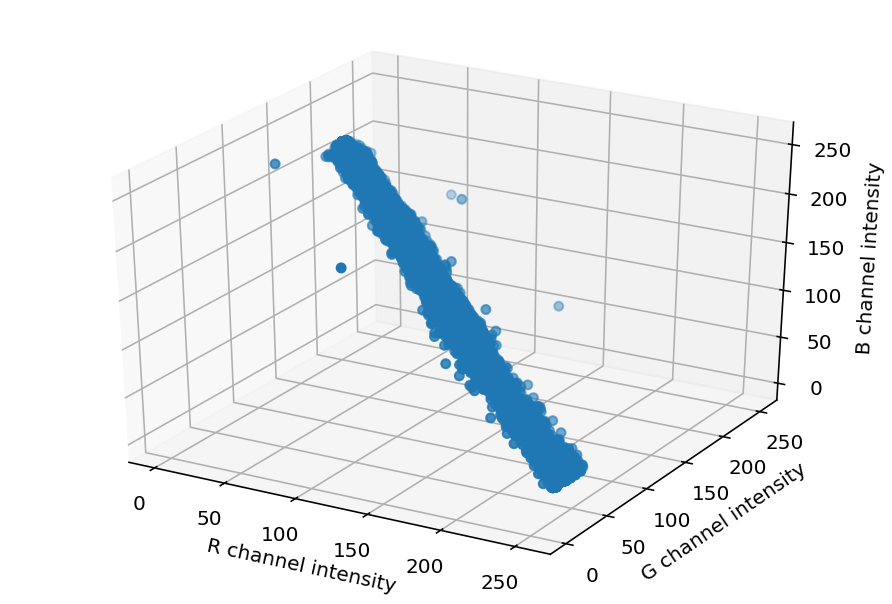

In [51]:
#visuliaze the decorrelation stretching plot after the decorrelation stretching
DeStrTorF=input()
if DeStrTorF=="T":
    r, g, b = cv2.split(image_destre)
    r = r.flatten()
    g = g.flatten()
    b = b.flatten()#plotting 
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(r, g, b)
    ax.set_xlabel('R channel intensity')
    ax.set_ylabel('G channel intensity')
    ax.set_zlabel('B channel intensity')
    plt.show()
else:
    pass

 T


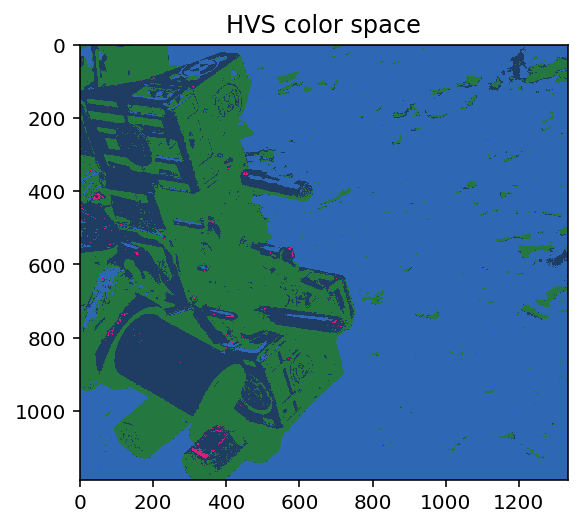

In [20]:
KmeanTorF=input()
if KmeanTorF=="T":
    #k-means method for image segmentation
    #Imag=image_destre
    reshapedImage = np.float32(Imag.reshape(-1, 3)) #conver the input (m,n,3) shape into (m*n,3) shape
    numberOfClusters = 4
    #define the number of cluster 
    stopCriteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.5)# either stop when there's no significant change after an iteration or when a big number of iterations has passed
    ret, labels, clusters = cv2.kmeans(reshapedImage, numberOfClusters, None, stopCriteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    clusters = np.uint8(clusters)
    intermediateImage = clusters[labels.flatten()]
    clusteredImage = intermediateImage.reshape((Imag.shape))
    plt.imshow(clusteredImage)
    plt.title('HVS color space')
    #plt.title('iteration number:%i' %numberOfClusters)#cv2.TERM_CRITERIA_EPS +
else:
    pass

In [20]:
Imag.shape

(1171, 1242, 3)

In [ ]:
MSTorF=input()
if MSTorF=="T":
    originImg= Imag  
    originShape = originImg.shape 
    flatImg=np.reshape(originImg, [-1, 3])  
    bandwidth = estimate_bandwidth(flatImg, quantile=0.1, n_samples=1000000)## Estimate bandwidth for meanshift algorithm  h 
    ms = MeanShift(bandwidth = bandwidth, bin_seeding=True)#change the parameter    
    ms.fit(flatImg)  
    labels=ms.labels_ # (r,g,b) vectors corresponding to the different clusters after meanshift     
    cluster_centers = ms.cluster_centers_ # Remaining colors after meanshift 
    labels_unique = np.unique(labels)# Finding and diplaying the number of clusters      
    n_clusters_ = len(labels_unique)    
    print("number of estimated clusters : %d" % n_clusters_)    
    segmentedImg = np.reshape(labels, originShape[:2])
    plt.imshow(segmentedImg) 
    #bandwidth is very small-oversegmentation
else:
    pass

 T


In [ ]:
#Kmeans clustering using cosine distance function-credit to Ian Detore
A = Imag.reshape(-1,3).astype(np.float)
k = 5
n = len(A)
cnts = np.zeros((k,3))
m=math.ceil(n*random.uniform(0,1))
cnts[0] = A[(m-1)]
#Select Random K Coordinates
for i in range(2,k+1):
    dmax = 0
    for j in range(1,n+1):
        dmin = 1000
        pj = A[j-1]
        for l in range(1,i):
            d = 1 - np.dot(pj,cnts[l-1])/(np.linalg.norm(pj)*np.linalg.norm(cnts[l-1]))
            if d<dmin:
                dmin=d
        if dmin>dmax:
            cnts[i-1] = pj
clusters = np.zeros((n,1))
for j in range(1,n+1):
    dmin = 1000
    for i in range(1,k+1):
        d = 1 - np.dot(A[j-1],cnts[i-1])/(np.linalg.norm(A[j-1])*np.linalg.norm(cnts[i-1]))
        if d<dmin:
            dmin=d
            clusters[j-1] = i
image = A.reshape((Imag.shape))
for i in range(1,k+1):
    idx = np.argwhere(clusters==i) 
    A[idx] = math.ceil(255*random.uniform(0,1))
image = (A.reshape((Imag.shape)))
grayExtract = np.unique(image.reshape(-1, image.shape[2]), axis=0)
if len(grayExtract)!= k:
    dif = k-len(grayExtract)
    for i in range(1,dif+1):
        grayExtract = np.vstack([grayExtract,[None,None,None]])
for i in range(1,k+1):
    idx = np.argwhere(image[:,:,1]==grayExtract[i-1,1])
    x1 = [w[0] for w in idx] 
    y1 = [w[1] for w in idx] 
    image[x1,y1,0] = int(math.ceil(255*random.uniform(0,1))*random.uniform(0,1))
    image[x1,y1,1] = int(math.ceil(255*random.uniform(0,1))*random.uniform(0,1))
    image[x1,y1,2] = int(math.ceil(255*random.uniform(0,1))*random.uniform(0,1))
plt.imshow(image.astype(np.uint8))